# Clustering of scikit-learn toy data sets (hierarchically)

Go to:

  - [Notebook configuration](scikit_learn_datasets_hierarchical.ipynb#Notebook-configuration)
  - [Data set generation](scikit_learn_datasets_hierarchical.ipynb#Data-set-generation)

  - CommonNN clustering using ...
    - [... point coordinates](scikit_learn_datasets_hierarchical.ipynb#CommonNN-clustering-using-data-point-coordinates-as-input)
    - [... pre-computed sorted neighbourhoods](scikit_learn_datasets_hierarchical.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods-(sorted-by-member-index))
    - [... pre-computed doubly sorted neighbourhoods](scikit_learn_datasets_hierarchical.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods-(sorted-by-member-index-and-neighbour-count))
    - [... pre-computed doubly sorted neighbourhoods (debug)](scikit_learn_datasets_hierarchical.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods-(sorted-by-member-index-and-neighbour-count;-debug))
    

## Notebook configuration

In [25]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

import commonnn
from commonnn import cluster, recipes
from commonnn import _types, _fit

In [2]:
# Helper function definitions
def indent_at_parens(s):
    """Take a string and introduce indention at parentheses"""

    o = ""
    level = 1
    saw_comma = False
    for c in s:
        if saw_comma:
            if c == " ":
                o += f"\n{'    ' * (level - 1)}"
            else:
                o += f"\n{'    ' * (level - 1)}{c}"
            saw_comma = False
            continue

        if c == "(":
            o += f"(\n{'    ' * level}"
            level += 1
            continue

        if c == ")":
            level -= 1
            o += f"\n{'    ' * level})"
            continue

        if c == ",":
            saw_comma = True
            o += ","
            continue

        o += c

    return o

Print Python and package version information:

In [3]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, sklearn, commonnn]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:57:39)  [GCC 9.3.0]
Packages:
    matplotlib: 3.9.4
    numpy: 1.26.4
    sklearn: 1.6.1
    commonnn: 0.0.4


We use [Matplotlib](https://matplotlib.org/) to create plots. The `matplotlibrc` file in the root directory of the `CommonNNClustering` repository is used to customize the appearance of the plots.

In [4]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [5]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

## Data set generation

To see the common-nearest-neighbours (CommonNN) clustering in action, let's have a look at a handful of basic 2D data sets from scikit-learn (like here in the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)). We will cluster the data sets starting from different input data formats using the provided defaults. For more details see also the [Advanced usage](advanced_usage.ipynb) tutorial. Technically, none of these examples requires a hierarchical approach. See [Hierarchical clustering basics](hierarchical_clustering_basics.ipynb) for an example where hierarchical clustering is more relevant. Note also that we do actully not look at the resulting hierarchies here but should select leafs based on large member cutoffs based on our expectation. Apart from that, little parameter tweaking is needed. The same radius cutoff is usable in all cases and the result is insenstive to the exact choice.

In [6]:
# Data set generation parameters
np.random.seed(0)
n_samples = 2000

In [7]:
# Data set generation
# Fit all datasets to the same value range
#    using `data = StandardScaler().fit_transform(data)`

# circles
noisy_circles, _ = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
    )
noisy_circles = StandardScaler().fit_transform(noisy_circles)

# moons
noisy_moons, _ = datasets.make_moons(
    n_samples=n_samples,
    noise=.05
    )
noisy_moons = StandardScaler().fit_transform(noisy_moons)

# blobs
blobs, _ = datasets.make_blobs(
    n_samples=n_samples,
    random_state=8
    )
blobs = StandardScaler().fit_transform(blobs)

# None
no_structure = np.random.rand(
    n_samples, 2
    )
no_structure = StandardScaler().fit_transform(no_structure)

# aniso
random_state = 170
X, y = datasets.make_blobs(
    n_samples=n_samples,
    random_state=random_state
    )

transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso = np.dot(X, transformation)
aniso = StandardScaler().fit_transform(aniso)

# varied
varied, _ = datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
    )
varied = StandardScaler().fit_transform(varied)

In [20]:
# Define cluster parameters
dsets = [ # "name", set, **parameters
    ('circles', noisy_circles, {
        'radius_cutoff': 0.5,
        'member_cutoff': 500,
        }),
    ('moons', noisy_moons, {
        'radius_cutoff': 0.5,
        'member_cutoff': 500,
        }),
    ('varied', varied, {
        'radius_cutoff': 0.5,
        'member_cutoff': 200,
        }),
    ('aniso', aniso, {
        'radius_cutoff': 0.5,
        'member_cutoff': 200,
         }),
    ('blobs', blobs, {
        'radius_cutoff': 0.5,
        'member_cutoff': 600,
        }),
    ('None', no_structure, {
        'radius_cutoff': 0.5,
        'member_cutoff': 1000,
        'make_labels': False
        }),
    ]

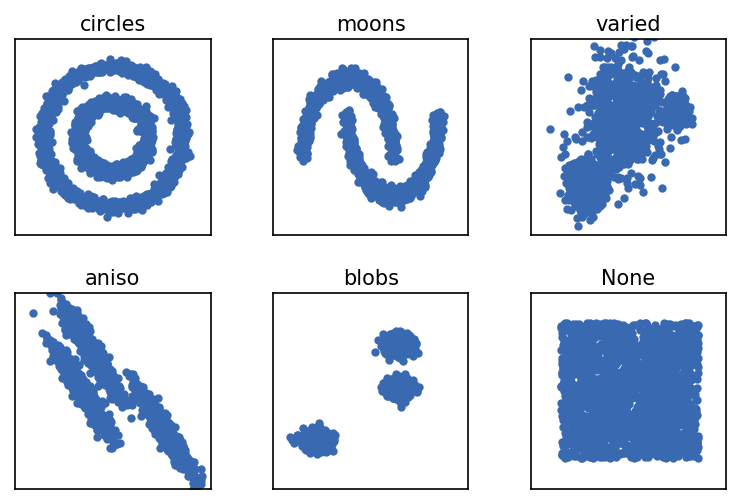

In [21]:
# Plot the original data sets
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, *_) in enumerate(dsets):
    Ax[count].plot(data[:, 0], data[:, 1], **line_props)
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

## CommonNN clustering using data point coordinates as input

2025-04-09 18:42:27.332 | INFO     | __main__:<module>:9 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:42:30.335 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 18:42:30.336 | INFO     | __main__:<module>:9 - Computed Scipy Z matrix
2025-04-09 18:42:30.344 | INFO     | __main__:<module>:9 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:42:30.345 | INFO     | __main__:<module>:9 - Converted all leafs to root labels
2025-04-09 18:42:30.348 | INFO     | __main__:<module>:9 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:42:35.199 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 18:42:35.201 | INFO     | __main__:<module>:9 - Computed Scipy Z matrix
2025-04-09 18:42:35.211 | INFO     | __main__:<module>:9 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:42:35.212 | INFO     | __main__:<module>:9 - Converted all leafs to root labels
2025-04-09

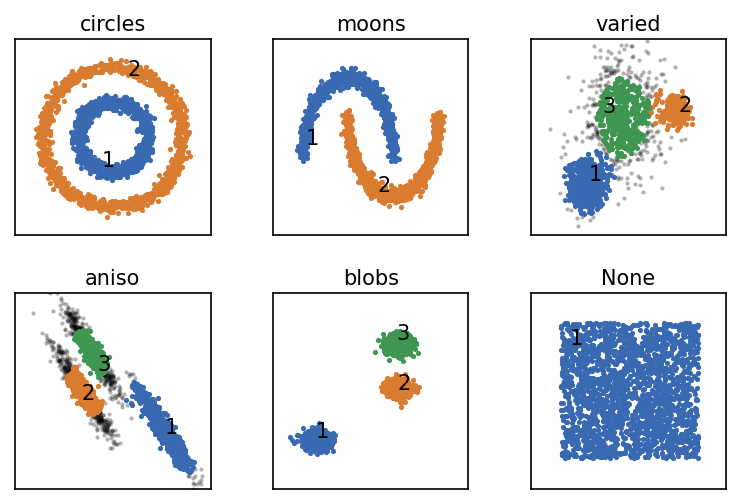

In [22]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    # Default clustering initialisation
    clustering = cluster.Clustering(data, recipe="coordinates_mst")

    # Calculate neighbours brute force
    clustering.fit_hierarchical(**params)

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

When *raw* input data is presented to a `Clustering` on creation without specifying anything else, the obtained `Clustering` object aggregates the needed clustering components, assuming that it got point coordinates as a sequence of sequences. The neighbourhood of a specific point will be collected brute-force by computing the (Euclidean) distances to all other points and comparing them to the radius cutoff. This will be the slowest possible approach but it has fairly conservative memory usage.

In [ ]:
# Clustering components used by default ("coordinates_mst" recipe)
print(indent_at_parens(str(clustering)))

Clustering(
    input_data=InputDataExtComponentsMemoryview(
        components of 2000 points in 2 dimensions
        ),
    fitter=None,
    hierarchical_fitter=HierarchicalFitterExtCommonNNMSTPrim(
        ngetter=NeighboursGetterExtBruteForce(
            dgetter=DistanceGetterExtMetric(
                metric=MetricExtEuclideanReduced
                ),
            sorted=False,
            selfcounting=True
            ),
        na=NeighboursExtVectorUnorderedSet,
        nb=NeighboursExtVectorUnorderedSet,
        checker=SimilarityCheckerExtSwitchContains,
        prioq=PriorityQueueExtMaxHeap,
        prioq_tree=PriorityQueueExtMaxHeap
        ),
    predictor=None
    )


## CommonNN clustering with pre-computed neighbourhoods (sorted by member index)

2025-04-09 18:51:01.145 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim


2025-04-09 18:51:01.305 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 18:51:01.306 | INFO     | __main__:<module>:20 - Computed Scipy Z matrix
2025-04-09 18:51:01.314 | INFO     | __main__:<module>:20 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:51:01.315 | INFO     | __main__:<module>:20 - Converted all leafs to root labels
2025-04-09 18:51:01.347 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:51:01.658 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 18:51:01.659 | INFO     | __main__:<module>:20 - Computed Scipy Z matrix
2025-04-09 18:51:01.669 | INFO     | __main__:<module>:20 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:51:01.671 | INFO     | __main__:<module>:20 - Converted all leafs to root labels
2025-04-09 18:51:01.715 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
20

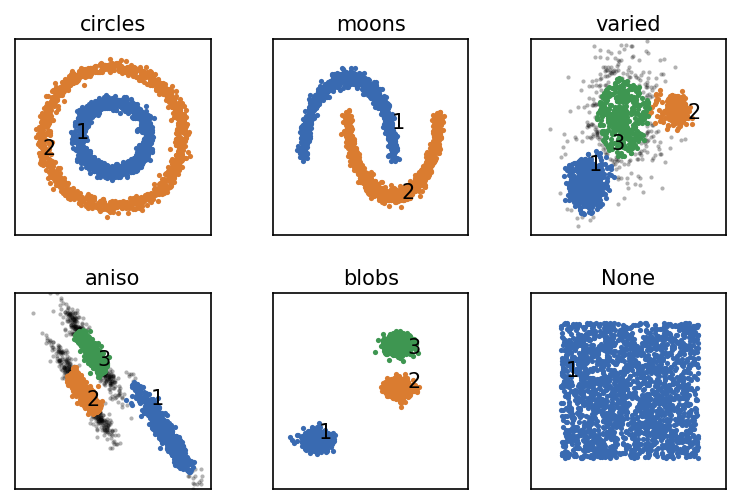

In [26]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    # Reference clustering
    clustering = cluster.Clustering(data)  
    
    # Pre-compute and sort neighbourhoods and choose the corresponding recipe
    neighbourhoods = recipes.sorted_neighbourhoods_from_coordinates(
        data, r=params["radius_cutoff"], sort_by="indices"
    )

    clustering_neighbourhoods_sorted = cluster.Clustering(
        neighbourhoods,
        recipe="sorted_neighbourhoods_mst"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods_sorted.fit_hierarchical(**params)
    clustering.labels = clustering_neighbourhoods_sorted.labels

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

Pre-computed neighbourhood information can be sorted in terms of the indices of the members (i.e. so that within each neighbourhood the members are stored in increasing order of there index in the data set). While this has the same memory demand as using unsorted neighbourhoods, it allows faster clustering.

In [27]:
# Clustering components used by the "sorted_neighbourhoods_mst" recipe
print(indent_at_parens(str(clustering_neighbourhoods_sorted)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=None,
    hierarchical_fitter=HierarchicalFitterExtCommonNNMSTPrim(
        ngetter=NeighboursGetterExtLookup(
            sorted=True,
            selfcounting=True
            ),
        na=NeighboursExtVector,
        nb=NeighboursExtVector,
        checker=SimilarityCheckerExtScreensorted,
        prioq=PriorityQueueExtMaxHeap,
        prioq_tree=PriorityQueueExtMaxHeap
        ),
    predictor=None
    )



## CommonNN clustering with pre-computed neighbourhoods (sorted by member index and neighbour count)

2025-04-09 18:53:52.871 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:53:53.025 | INFO     | commonnn.report:wrapper:248 - Built MST


2025-04-09 18:53:53.026 | INFO     | __main__:<module>:20 - Computed Scipy Z matrix
2025-04-09 18:53:53.034 | INFO     | __main__:<module>:20 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:53:53.036 | INFO     | __main__:<module>:20 - Converted all leafs to root labels
2025-04-09 18:53:53.066 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:53:53.344 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 18:53:53.346 | INFO     | __main__:<module>:20 - Computed Scipy Z matrix
2025-04-09 18:53:53.355 | INFO     | __main__:<module>:20 - Built bundle hierarchy from Scipy Z matrix
2025-04-09 18:53:53.356 | INFO     | __main__:<module>:20 - Converted all leafs to root labels
2025-04-09 18:53:53.399 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterExtCommonNNMSTPrim
2025-04-09 18:53:54.742 | INFO     | commonnn.report:wrapper:248 - Built MST
20

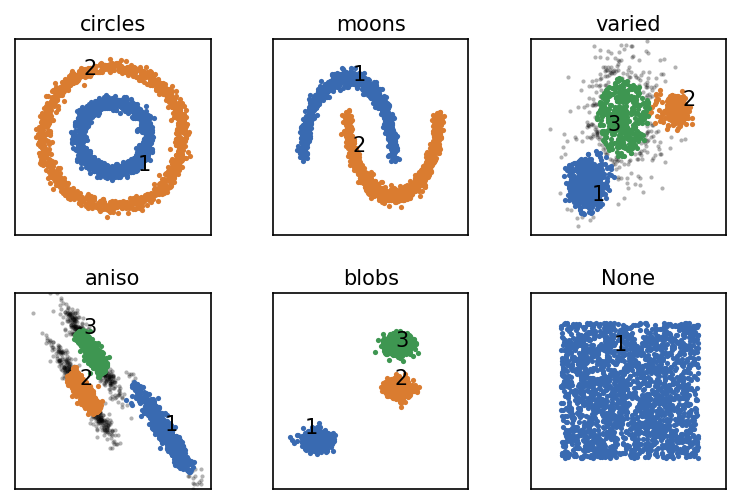

In [28]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    # Reference clustering
    clustering = cluster.Clustering(data)  
    
    # Pre-compute and sort neighbourhoods and choose the corresponding recipe
    neighbourhoods, sort_order, revert_order = recipes.sorted_neighbourhoods_from_coordinates(
        data, r=params["radius_cutoff"], sort_by="both"
    )

    clustering_neighbourhoods_sorted = cluster.Clustering(
        neighbourhoods,
        recipe="sorted_neighbourhoods_mst"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods_sorted.fit_hierarchical(**params)
    clustering.labels = clustering_neighbourhoods_sorted.labels[revert_order]

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

As a further addition to the sorting of each neighbourhood by member indices, it is possible to sort all neighbourhoods according to their member count (i.e. so that the point with the highest neighbour count becomes the first point in the data set). It is not guaranteed but this additional sorting can make the clustering even more efficient.

In [29]:
# Clustering components used by the "sorted_neighbourhoods_mst" recipe
print(indent_at_parens(str(clustering_neighbourhoods_sorted)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=None,
    hierarchical_fitter=HierarchicalFitterExtCommonNNMSTPrim(
        ngetter=NeighboursGetterExtLookup(
            sorted=True,
            selfcounting=True
            ),
        na=NeighboursExtVector,
        nb=NeighboursExtVector,
        checker=SimilarityCheckerExtScreensorted,
        prioq=PriorityQueueExtMaxHeap,
        prioq_tree=PriorityQueueExtMaxHeap
        ),
    predictor=None
    )



## CommonNN clustering with pre-computed neighbourhoods (sorted by member index and neighbour count; debug)

2025-04-09 19:04:08.931 | INFO     | __main__:<module>:20 - Started hierarchical CommonNN clustering - HierarchicalFitterCommonNNMSTPrim
2025-04-09 19:04:09.139 | INFO     | commonnn.report:wrapper:248 - Built MST
2025-04-09 19:04:09.140 | DEBUG    | __main__:<module>:20 - 1999 edges in MST
2025-04-09 19:04:09.141 | DEBUG    | __main__:<module>:20 - Iteration 0: Points 2 (cluster 2) and 3 (cluster 3) connect at weight=198.0
2025-04-09 19:04:09.141 | DEBUG    | __main__:<module>:20 - Iteration 1: Points 0 (cluster 0) and 1 (cluster 1) connect at weight=198.0
2025-04-09 19:04:09.141 | DEBUG    | __main__:<module>:20 - Iteration 2: Points 8 (cluster 8) and 6 (cluster 6) connect at weight=197.0
2025-04-09 19:04:09.141 | DEBUG    | __main__:<module>:20 - Iteration 3: Points 1 (cluster 2001) and 11 (cluster 11) connect at weight=196.0
2025-04-09 19:04:09.141 | DEBUG    | __main__:<module>:20 - Iteration 4: Points 0 (cluster 2003) and 12 (cluster 12) connect at weight=196.0
2025-04-09 19:04:0

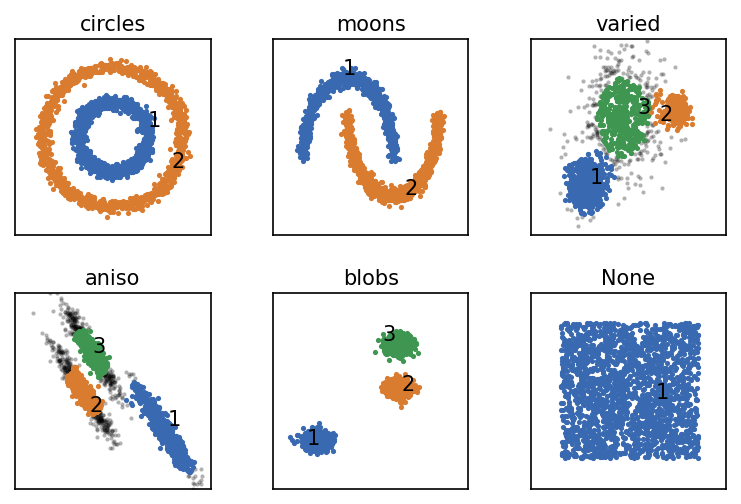

In [30]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    # Reference clustering
    clustering = cluster.Clustering(data)  
    
    # Pre-compute and sort neighbourhoods and choose the corresponding recipe
    neighbourhoods, sort_order, revert_order = recipes.sorted_neighbourhoods_from_coordinates(
        data, r=params["radius_cutoff"], sort_by="both"
    )

    clustering_neighbourhoods_sorted = cluster.Clustering(
        neighbourhoods,
        recipe="sorted_neighbourhoods_mst_debug"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods_sorted.fit_hierarchical(**params)
    clustering.labels = clustering_neighbourhoods_sorted.labels[revert_order]

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

In [31]:
# Clustering components used by the "sorted_neighbourhoods_mst_debug" recipe
print(indent_at_parens(str(clustering_neighbourhoods_sorted)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=None,
    hierarchical_fitter=HierarchicalFitterCommonNNMSTPrim(
        ngetter=NeighboursGetterExtLookup(
            sorted=True,
            selfcounting=True
            ),
        na=NeighboursExtVector,
        nb=NeighboursExtVector,
        checker=SimilarityCheckerExtScreensorted,
        prioq=PriorityQueueExtMaxHeap,
        prioq_tree=PriorityQueueExtMaxHeap
        ),
    predictor=None
    )
